In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
import torch
from transformers import BertModel, AutoTokenizer
import torch
from torch.nn.functional import cosine_similarity
from tqdm import tqdm
import numpy as np
import pandas as pd
import json
from datasets import load_dataset

In [3]:
MODEL_ID = "google-bert/bert-base-multilingual-uncased"
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
dataset = load_dataset('./wsd_polish_datasets')

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'tokens', 'phrases', 'wsd'],
        num_rows: 7848
    })
})

In [6]:
dataset = dataset['train']

In [7]:
words = [
    i['orth'] for i in dataset['tokens']
]


In [8]:
del dataset

In [9]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
bert_model = BertModel.from_pretrained(MODEL_ID).to(DEVICE)

In [10]:
inputs = tokenizer(['siema', 'mordeczko', 'co', 'tam'], return_tensors='pt', padding=True, truncation=True, is_split_into_words=True)

In [11]:
def get_word_embeddings(word_lists, tokenizer, model, device, batch_size=2):
    word_embeddings = []

    for i in tqdm(range(0, len(word_lists), batch_size)):
        batch = word_lists[i:i + batch_size]
        inputs = tokenizer(batch, return_tensors='pt', padding=True, truncation=True, is_split_into_words=True).to(device)

        with torch.no_grad():
            outputs = model(**inputs, return_dict=True, output_hidden_states=True)

        hidden_states = outputs.hidden_states
        hidden_states = tuple([layer.to('cpu') for layer in hidden_states])

        del outputs

        for b in range(len(batch)):
            word_embs_per_layer = []

            for layer in hidden_states:

                token_embeddings = layer[b]  # Get the embeddings for the b-th text in the batch
                word_ids = inputs.word_ids(batch_index=b)

                word_embs = []
                current_word_emb = []
                current_word_id = None

                for j, word_id in enumerate(word_ids):

                    if word_id is None:
                        continue

                    if (word_id == current_word_id) or (current_word_id is None):
                        current_word_emb.append(token_embeddings[j])
                    else:
                        word_embs.append(torch.mean(torch.stack(current_word_emb), dim=0))
                        current_word_emb = [token_embeddings[j]]

                    current_word_id = word_id

                if current_word_emb:
                    word_embs.append(torch.mean(torch.stack(current_word_emb), dim=0))

                word_embs_per_layer.append(torch.stack(word_embs))

            word_embeddings.append(word_embs_per_layer)

    return word_embeddings

In [57]:
word_embeddings = get_word_embeddings(words[:128], tokenizer, bert_model, DEVICE, batch_size=64)

100%|██████████| 2/2 [00:04<00:00,  2.34s/it]


In [13]:
def calculate_average_cosine_similarity(word_embeddings, n=100):
    
    layer_similarities = {}

    for layer in range(len(word_embeddings[0])):

        all_embeddings = torch.concat([text_embs[layer] for text_embs in word_embeddings])
        num_embeddings = all_embeddings.size(0)

        # Sample n pairs of indices
        indices = torch.randint(0, num_embeddings, (n, 2))

        # Get the embeddings for the sampled pairs
        emb1 = all_embeddings[indices[:, 0]]
        emb2 = all_embeddings[indices[:, 1]]

        # Calculate cosine similarity for the sampled pairs
        similarities = cosine_similarity(emb1, emb2, dim=1)

        average_similarity = similarities.mean().item()
        layer_similarities[layer] = average_similarity

    return layer_similarities

In [58]:
layer_similarities = calculate_average_cosine_similarity(word_embeddings, n=100)

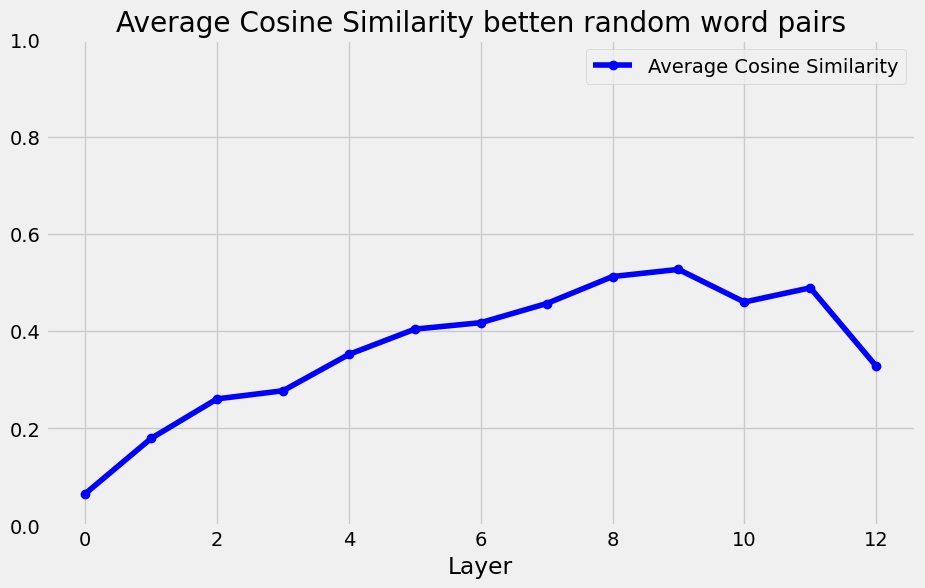

In [59]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# Extract layers and their corresponding similarities
layers = list(layer_similarities.keys())
similarities = list(layer_similarities.values())

# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(layers, similarities, marker='o', linestyle='-', color='b', label='Average Cosine Similarity')

# Add title and labels
plt.title('Average Cosine Similarity betten random word pairs')
plt.xlabel('Layer')
plt.ylabel('')

# Set y-axis scale from 0 to 1
plt.ylim(0, 1)

# Add legend
plt.legend()

# Show plot
plt.grid(True)
plt.show()

In [60]:
from collections import defaultdict

In [64]:
def calculate_average_cosine_similarity_same_words(word_embeddings, words, n=100):

    layer_similarities = {}

    for layer in range(len(word_embeddings[0])):
        word_to_embeddings = defaultdict(list)

        for text_embs, text_words in zip(word_embeddings, words):

            for word, emb in zip(text_words, text_embs[layer]):
                word_to_embeddings[word].append(emb)

        print(f'{word_to_embeddings.keys() = }')

        word_similarities = {}

        for word, embeddings in word_to_embeddings.items():

            # word_similarities[word] = None

            if len(embeddings) > 2:

                embeddings = torch.stack(embeddings)
                print(f'{embeddings.shape = }')
                
                sim = cosine_similarity(embeddings.unsqueeze(1), embeddings.unsqueeze(0), dim=2)
                print(f'{sim.shape = }')
                triu_indices = torch.triu_indices(sim.size(0), sim.size(1), offset=1)
                sim_values = sim[triu_indices[0], triu_indices[1]]
                word_similarities[word] = sim_values.mean().item()

        layer_similarities[layer] = word_similarities

    return layer_similarities

In [65]:
word_sims = calculate_average_cosine_similarity_same_words(word_embeddings, words[:128], n=100)

word_to_embeddings.keys() = dict_keys(['Zatem', 'to', 'pani', 'siostra', 'o', 'niego', 'prosiła', '?', 'Skądże', ',', 'nigdy', 'nie', 'słyszała', 'm', 'żeby', 'go', 'używała', '.', 'Zwykły', 'śmy', 'obywać', 'się', 'bez', 'służących', 'W', 'istocie', 'wydaje', 'niepotrzebnym', 'umieszczanie', 'tak', 'porządnego', 'sznura', 'w', 'tym', 'miejscu', 'Bądźcie', 'teraz', 'uprzejmi', 'i', 'dajcie', 'mi', 'kilka', 'minut', 'na', 'bliższe', 'zapoznanie', 'z', 'podłogą', 'Holmes', 'przypadł', 'do', 'podłogi', 'pełzał', 'te', 'wewte', 'ze', 'szkłem', 'powiększającym', 'dłoni', 'skupieniem', 'badając', 'przerwy', 'między', 'deskami', 'Następnie', 'podobny', 'sposób', 'przyjrzał', 'deskom', 'ścianach', 'komnaty', 'Potem', 'podszedł', 'łóżka', 'przez', 'jakiś', 'czas', 'przyglądał', 'uważnie', 'zarówno', 'jemu', 'jak', 'przylegającej', 'ń', 'ścianie', 'Wreszcie', 'chwycił', 'sznur', 'energicznie', 'pociągnął', 'Ależ', 'przecież', 'atrapa', '-', 'powiedział', 'Nie', 'dzwoni', 'Bynajmniej', 'jest', 'n

In [66]:
word_sims

{0: {'Zatem': 0.9195931553840637,
  'to': 0.8772463202476501,
  'pani': 0.9338851571083069,
  'siostra': 0.8569141626358032,
  'o': 0.8900005221366882,
  'niego': 0.9197627305984497,
  '?': 0.9204598665237427,
  ',': 0.7927544116973877,
  'nigdy': 0.934251606464386,
  'nie': 0.907016932964325,
  'słyszała': 0.7989728450775146,
  'm': 0.8901668190956116,
  'żeby': 0.8589588403701782,
  'go': 0.9070531725883484,
  '.': 0.8021199703216553,
  'śmy': 0.8425453305244446,
  'się': 0.9039329886436462,
  'bez': 0.9174715876579285,
  'W': 0.8703701496124268,
  'istocie': 0.8721514344215393,
  'tak': 0.9225183725357056,
  'w': 0.8694526553153992,
  'tym': 0.9245842695236206,
  'miejscu': 0.9274886250495911,
  'teraz': 0.9173336029052734,
  'i': 0.8694331645965576,
  'mi': 0.9186509847640991,
  'kilka': 0.8902796506881714,
  'minut': 0.9327922463417053,
  'na': 0.8795651793479919,
  'z': 0.8811568021774292,
  'Holmes': 0.919693648815155,
  'do': 0.8903132677078247,
  'podłogi': 0.8177483081817627,

In [67]:
mean_layer_sims = {layer: np.mean(list(word_sims[layer].values())) for layer in word_sims}

In [68]:
mean_layer_sims

{0: 0.8844229470843497,
 1: 0.8637188829403409,
 2: 0.8497251596586637,
 3: 0.8208045200786848,
 4: 0.8081710913192028,
 5: 0.790426598585349,
 6: 0.770470878799101,
 7: 0.7807587451305704,
 8: 0.7801718710959404,
 9: 0.7934166189433931,
 10: 0.774143582162471,
 11: 0.7955985319489303,
 12: 0.7590002052296048}

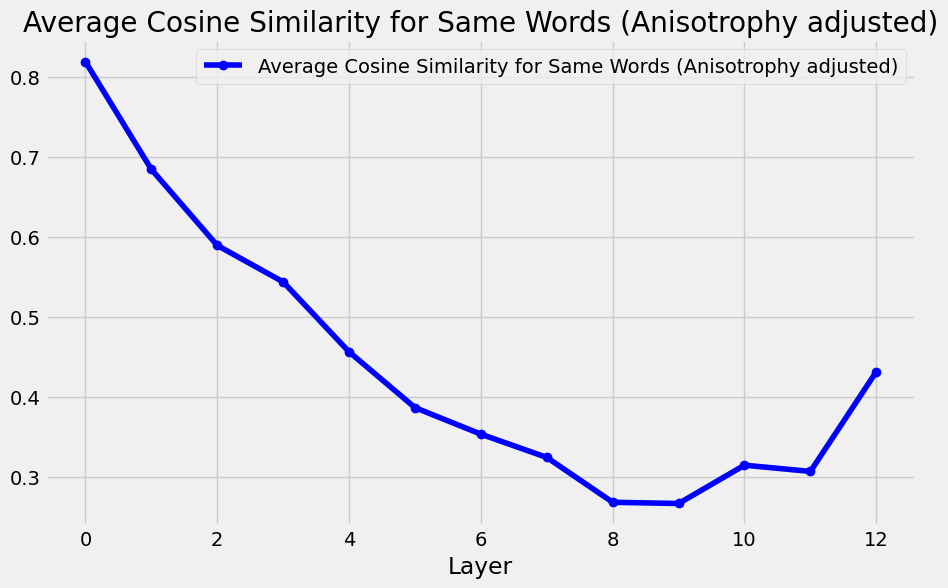

In [79]:
layers = list(mean_layer_sims.keys())
similarities = np.array(list(mean_layer_sims.values())) - np.array(list(layer_similarities.values()))

# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(layers, similarities, marker='o', linestyle='-', color='b', label='Average Cosine Similarity for Same Words (Anisotrophy adjusted)')

# Add title and labels
plt.title('Average Cosine Similarity for Same Words (Anisotrophy adjusted)')
plt.xlabel('Layer')
plt.ylabel('')

# Add legend
plt.legend()

# Show plot
plt.grid(True)
plt.show()

In [82]:
import re

In [126]:
def get_sentence_embeddings_from_word_embeddings(word_embeddings, words):

    sentence_indices = []
    current_sentence = []

    for word_list in words:

        for i, word in enumerate(word_list):
            current_sentence.append(word)

            if i != len(word_list) - 1:

                if (word in ['!', '?', '.']) and (word_list[i + 1].istitle()):
                    sentence_indices.append(current_sentence)
                    current_sentence = []

        if current_sentence:
            sentence_indices.append(current_sentence)
            current_sentence = []

    return sentence_indices

In [127]:
sentences = get_sentence_embeddings_from_word_embeddings(word_embeddings, words[:128])

In [128]:
word_embeddings_sentences = get_word_embeddings(sentences, tokenizer, bert_model, DEVICE, batch_size=64)

100%|██████████| 22/22 [00:05<00:00,  4.32it/s]


In [158]:
def calculate_average_cosine_similarity_sentence(words_sentence_embeddings, n=100):
    
    layer_similarities = {}

    for layer in range(len(words_sentence_embeddings[0])):

        layer_similarities[layer] = []

        for sentence_words in words_sentence_embeddings:

            sentence_emb = torch.mean(sentence_words[layer], dim=0)
            sent_cosine_sim = cosine_similarity(sentence_emb.unsqueeze(0), sentence_words[layer], dim=1).mean().item()

            layer_similarities[layer].append(sent_cosine_sim)

        layer_similarities[layer] = np.mean(layer_similarities[layer])

    return layer_similarities

In [159]:
mean_sent_sims = calculate_average_cosine_similarity_sentence(word_embeddings_sentences, n=100)

In [160]:
mean_sent_sims

{0: 0.4426509468618009,
 1: 0.5394418102746107,
 2: 0.6397263987245086,
 3: 0.6881424268984586,
 4: 0.7156359600690642,
 5: 0.7256277435983235,
 6: 0.7442752920938303,
 7: 0.7751170092699479,
 8: 0.8033162866754365,
 9: 0.8268045577989028,
 10: 0.8290031096156762,
 11: 0.853788055544692,
 12: 0.6853730594712165}

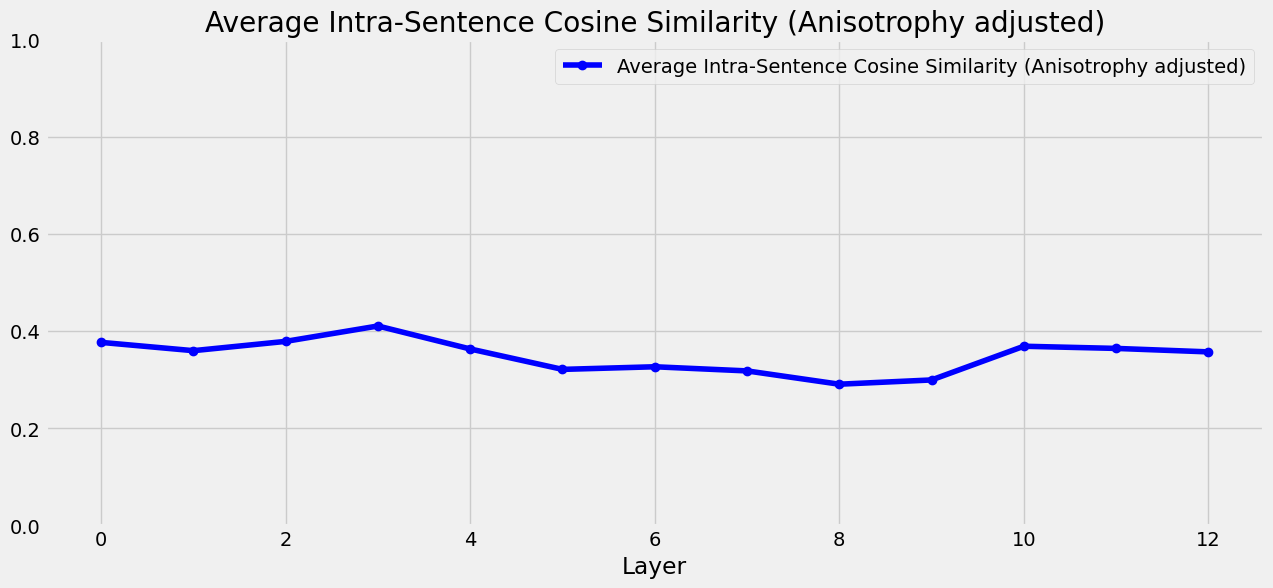

In [163]:
layers = list(mean_sent_sims.keys())
similarities = np.array(list(mean_sent_sims.values())) - np.array(list(layer_similarities.values()))

# Create a line plot
plt.figure(figsize=(14, 6))
plt.plot(layers, similarities, marker='o', linestyle='-', color='b', label='Average Intra-Sentence Cosine Similarity (Anisotrophy adjusted)')

# Add title and labels
plt.title('Average Intra-Sentence Cosine Similarity (Anisotrophy adjusted)')
plt.xlabel('Layer')
plt.ylabel('')


plt.ylim(0, 1)
# Add legend
plt.legend()

# Show plot
plt.grid(True)
plt.show()